# Compare pipeline perdictions -- 3VOTE

In [3]:
import os
import re
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
def get_record(file):
    df = pd.read_csv(file)
    df = df.drop_duplicates(['Trading Date', 'Symbol'], keep='last')
    pivot_df = pd.pivot_table(df, values='Real Prediction', index='Trading Date', columns='Symbol')
    pivot_df.index = pd.to_datetime(pivot_df.index, format='%Y-%m-%d')
    return pivot_df

def get_3vote(file):
    df = pd.read_csv(file)
    df = df.drop_duplicates(['Trading Date', 'Symbol', 'setID'], keep='last')
    pivot_df = pd.pivot_table(df, values='Trend', index='Trading Date', columns=['setID', 'Symbol'])
    pivot_df.index = pd.to_datetime(pivot_df.index, format='%Y-%m-%d')
    return pivot_df


def get_label(dfclose, pp=21):
    dfclose.index = pd.to_datetime(dfclose.index, format='%Y-%m-%d').date
    y_pctch = -dfclose.pct_change(-pp).dropna(how='all')
    y_label = (y_pctch > 0).astype(int)
    return y_label

def get_label_from_file(file, pp=21):
    df = pd.read_csv(file)
    df = df.drop_duplicates(['date', 'code'], keep='last')
    pivot_df = pd.pivot_table(df, values='close', index='date', columns='code')
    
    ylabel = get_label(pivot_df, pp)
    return ylabel

In [5]:
    def gen_datelist(file, rebalance_freq, begin_date=None, end_date=None):
        tradedates = pd.read_csv(file)
        datelist = pd.to_datetime(
            tradedates['date'], format='%Y-%m-%d')#.dt.date
        datelist_all = pd.DataFrame(list(datelist), columns=['date'])
        datelist_all.index = datelist_all.date
        
        # cut begin-date if set
        if begin_date is not None:
            datelist_all = datelist_all[datelist_all.index >= begin_date]

        # cut end-date if set
        if end_date is not None:
            datelist_all = datelist_all[datelist_all.index <= end_date]

        datelist_rb = rebalance_date(datelist_all.index, rebalance_freq)
        datelist_rb = datelist_rb.reset_index(drop=True)

        return datelist_rb
    
    def rebalance_date(dates, freq='M'):
        """Get rebalance date base on frequence

        Args:
            dates (Index): All trade dates in special period
            freq (str, optional): the rebalance frequence

        Returns:
            pd.DataFrame: the selected rebalance date
        """
        dates = pd.to_datetime(dates)
        dts = pd.Series(dates, index=dates).sort_values()
        if '+' in freq:
            temp = []
            for sub_freq in freq.split('+'):
                sub_dts = group_series(dts, *parse_freq(sub_freq))
                temp.append(sub_dts)
            results = pd.concat(temp).drop_duplicates().sort_values()
        else:
            results = group_series(dts, *parse_freq(freq))

        results = results.reset_index(drop=True).rename(freq)
        results_df = results.to_frame()
        results_df[freq] = pd.to_datetime(
            results_df[freq], format='%Y-%m-%d')#.dt.date

        return results_df[freq]

    def group_series(dates, n_period, period, nth):
        """
        Args:
            dates (pd.Series): All trade dates in special period
            n_period (int): number of period
            period (str): frequency period
            nth (int): number of start point

        Returns:
            pd.DataFrame: the selected rebalance date
        """
        err = 'only support pandas.datetimeindex'
        assert isinstance(dates.index, pd.DatetimeIndex), err
        period_index = dates.index.to_period(period)
        if period != 'D':
            results = dates.groupby(period_index).nth(nth)
        else:
            results = dates[nth::n_period]
            n_period = 0
        if n_period > 1:
            results = results[::int(n_period)]
        return results.reset_index(drop=True)

    def parse_freq(s, default_num=1, default_nth=0):
        """Split frequency
        Args:
            s (str): rebalance frequence (e.g. 2M, 10D)
            default_num (int, optional): number of period
            default_nth (int, optional): number of start point

        Returns:
            num (int): number of period
            p (str): frequency period
            nth (int): number of start point

        Raises:
            KeyError: Wrong input format of Frequency
        """
        r = re.compile('(|\d+)([A-Za-z]+)(\d+|)')
        match = r.match(s)
        if not match:
            raise KeyError('Invalid format of Frequency [{}]'.format(s))
        num, p, nth = match.groups()
        num = int(num) if len(num) > 0 else default_num
        nth = int(nth) if len(nth) > 0 else default_nth
        return num, p, nth

In [6]:
def get_metircs(vote_df, tradedate_file, period=None, rebalance_freq=False):    
    if period is not None:
        try:
            vote_df = vote_df[period]
        except:
            vote_df = pd.DataFrame()

    sub_acc = pd.Series()
    m_count1 = pd.Series()
    preds_count = pd.Series()
    if not vote_df.empty:
        if rebalance_freq:
            rb_dates = gen_datelist(
                tradedate_file, rebalance_freq, vote_df.index[0], vote_df.index[-1])
            rb_dates = list(set(rb_dates).intersection(vote_df.index))
            vote_df = vote_df.loc[rb_dates, :]

        for asset in vote_df.columns:
            if asset not in y_df.columns:
                continue
            else:
                y = y_df[asset]
            preds = vote_df[asset]
            tmp = pd.concat([preds, y], axis=1).dropna()
#             print('{} start date: {}, end date: {}, number of predictions: {}'.format(
#                 asset, tmp.index[0], tmp.index[-1], len(tmp.index)))
            preds_count[asset] = len(tmp.index)
            sub_acc[asset] = accuracy_score(tmp.iloc[:, 1], tmp.iloc[:, 0])

            count = preds.value_counts()
            if len(count) == 0:
                m_count1[asset] = np.nan
            elif len(count) == 1:
                if count.index[0] == 1:
                    m_count1[asset] = 1
                else:
                    m_count1[asset] = 0
            else:
                m_count1[asset] = count[1.0]/count.sum()
            
    return sub_acc, m_count1, preds_count

## get data from database
- data.csv is price data
    - SQL: SELECT \`date\`, \`code\`,\`close\` FROM \`data\` WHERE \`code\` in ('DBC', 'EEM', 'IYR', 'TLT', 'VTI', 'SPY', 'QQQ', 'VGK', 'EWJ', 'GLD', 'LQD', 'VYM', 'TIP') and \`date\` >= '2021-01-01'
- live_vote3ETFs_preds.csv is the live 3VOTE predictions
    - rename them to start with site e.g. PROD_live_vote3ETFs_preds.csv
- date_features.csv yearly update is enough
    
## modify veriables
- record_fn is the folder where above .csv stored to
- sites are the list of sites
- ensemble_file is the file name of predictions
- rb_freq is a string to show what's the rebalance frequence
- cases is the list of measure setting (period, rebalance_only or not)
    - period = None means INCEPTION
    - rebalance_only options "M", "W" and False (False means all trade days)

In [7]:
record_fn = 'data'
t_assets = ['TLT', 'GLD', 'TIP']

In [8]:
tradedate_file = os.path.join(record_fn, 'date_features.csv')

# price_file = os.path.join(record_fn, 'data.csv')
price_file = os.path.join(record_fn, 'data(3vote).csv')
y_df = get_label_from_file(price_file, 10)
y_df.index = pd.to_datetime(y_df.index, format='%Y-%m-%d')
y_df.to_csv(os.path.join(record_fn, 'y_label_pp10D.csv'))

In [7]:
lastday = y_df.index[-1]
thisyear = lastday.year
prevyear = lastday.year - 1

tomonth_str = lastday.strftime("%Y-%m")

lastmonth = lastday - datetime.timedelta(days=35)
lastmonth_str = lastmonth.strftime("%Y-%m")

prevmonth = lastday - datetime.timedelta(days=50)
prevmonth_str = prevmonth.strftime("%Y-%m")

In [8]:
print("lastday: ", lastday)
print("thisyear: ", thisyear)
print("prevyear: ", prevyear)
print("tomonth_str: ", tomonth_str)
print("lastmonth_str: ", lastmonth_str)
print("prevmonth_str: ", prevmonth_str)

lastday:  2022-02-11 00:00:00
thisyear:  2022
prevyear:  2021
tomonth_str:  2022-02
lastmonth_str:  2022-01
prevmonth_str:  2021-12


## LIVE

In [9]:
sites = ['Bm5', 'bt']
ensemble_file = 'live_vote3ETFs_preds.csv'
rb_freq = 'M'

cases = [
    # (None, rb_freq), (None, False),
    # (tomonth_str, rb_freq), (tomonth_str, False),
    # (lastmonth_str, rb_freq), (lastmonth_str, False),
    # (prevmonth_str, rb_freq), (prevmonth_str, False),
    # (str(thisyear), rb_freq), (str(thisyear), False), 
    # (str(prevyear), rb_freq), (str(prevyear), False),

    ('2022', False), ('2022-01', False), ('2022-02', False),
    ('2022-03', False),
]

vote_acc_df = pd.DataFrame()
count1 = pd.DataFrame()
count_preds = pd.DataFrame()
for site in sites:
    # ensemble
    vote_file = os.path.join(os.path.join(record_fn, '{}_{}'.format(site, ensemble_file)))
    if not os.path.exists(vote_file):
        continue

    vote_df = get_3vote(vote_file)
    print("**********************************vote_file\n ", vote_file)
    for setID in list(set(vote_df.columns.get_level_values(0))):
        if setID == 0:
            continue
        tmp_df = vote_df[setID]
        
        subset_vote_acc_df = pd.DataFrame()
        subset_count1 = pd.DataFrame()
        subset_count_preds = pd.DataFrame()
        for case in cases:
            name = ""
            if case[0] is None:
                name += 'INCEPTION'
            else:
                name += case[0]

            if case[1]:
                name += '_rebalance_only'
            else:
                name += '_all_trade_days'
            name += "_" + site
            print("======={}======".format(name))
            case_acc, case_count1, case_preds_count = get_metircs(tmp_df, tradedate_file, case[0], case[1])

            case_acc.index = ["{}_{}".format(col, setID) for col in case_acc.index]
            subset_vote_acc_df[name] = case_acc
            case_count1.index = ["{}_{}".format(col, setID) for col in case_count1.index]
            subset_count1[name] = case_count1
            case_preds_count.index = ["{}_{}".format(col, setID) for col in case_preds_count.index]
            subset_count_preds[name] = case_preds_count

        subset_count1 = subset_count1.dropna(axis=1, how='all')
        subset_count1 = subset_count1.sort_index().sort_index(axis=1)
        count1 = pd.concat([count1, subset_count1])

        subset_count_preds = subset_count_preds.sort_index()
        subset_count_preds.loc['set {} total number of preds'.format(setID), :] = subset_count_preds.sum()
        if subset_count_preds.columns[0] in count_preds.columns:
            count_preds = pd.concat([count_preds, subset_count_preds])
        else:
            count_preds = pd.concat([count_preds, subset_count_preds], axis=1)

        subset_vote_acc_df = subset_vote_acc_df.dropna(axis=1, how='all')
        subset_vote_acc_df = subset_vote_acc_df.sort_index()
        subset_vote_acc_df.loc['set {} MEAN accuracy'.format(setID), :] = subset_vote_acc_df.mean()

        if subset_vote_acc_df.columns[0] in vote_acc_df.columns:
            vote_acc_df = pd.concat([vote_acc_df, subset_vote_acc_df])
        else:
            vote_acc_df = pd.concat([vote_acc_df, subset_vote_acc_df], axis=1)
            
count1 = count1.sort_index(axis=1)
count_preds = count_preds.sort_index(axis=1)
vote_acc_df = vote_acc_df.sort_index(axis=1)

**********************************vote_file
  data\Bm5_live_vote3ETFs_preds.csv
=======2022_all_trade_days_Bm5======
=======2022-01_all_trade_days_Bm5======
=======2022-02_all_trade_days_Bm5======
=======2022-03_all_trade_days_Bm5======
=======2022_all_trade_days_Bm5======
=======2022-01_all_trade_days_Bm5======
=======2022-02_all_trade_days_Bm5======
=======2022-03_all_trade_days_Bm5======
=======2022_all_trade_days_Bm5======
=======2022-01_all_trade_days_Bm5======
=======2022-02_all_trade_days_Bm5======
=======2022-03_all_trade_days_Bm5======
=======2022_all_trade_days_Bm5======
=======2022-01_all_trade_days_Bm5======
=======2022-02_all_trade_days_Bm5======
=======2022-03_all_trade_days_Bm5======
=======2022_all_trade_days_Bm5======
=======2022-01_all_trade_days_Bm5======
=======2022-02_all_trade_days_Bm5======
=======2022-03_all_trade_days_Bm5======
**********************************vote_file
  data\bt_live_vote3ETFs_preds.csv
=======2022_all_trade_days_bt======
=======2022-01_all_t

In [10]:
display = pd.concat(
    [vote_acc_df.loc[vote_acc_df.index.str.contains('MEAN accuracy'), :].T,
     count_preds.loc[count_preds.index.str.contains('total number of preds'), :].T], axis=1).dropna(how='all')
display.T.sort_index().T

,set 1 MEAN accuracy,set 1 total number of preds,set 2 MEAN accuracy,set 2 total number of preds,set 3 MEAN accuracy,set 3 total number of preds,set 4 MEAN accuracy,set 4 total number of preds,set 5 MEAN accuracy,set 5 total number of preds
2022-01_all_trade_days_Bm5,0.383333,60.0,0.383333,60.0,0.333333,60.0,0.333333,60.0,0.366667,60.0
2022-01_all_trade_days_bt,0.333333,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02_all_trade_days_Bm5,0.491228,57.0,0.574074,54.0,0.491228,57.0,0.578947,57.0,0.438596,57.0
2022-02_all_trade_days_bt,0.631579,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03_all_trade_days_Bm5,0.275362,69.0,0.304348,69.0,0.260870,69.0,0.217391,69.0,0.231884,69.0
2022-03_all_trade_days_bt,0.527778,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022_all_trade_days_Bm5,0.370667,375.0,0.353566,376.0,0.329021,380.0,0.352768,380.0,0.355704,377.0
2022_all_trade_days_bt,0.490196,153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'LIVE 3VOTE accuracy'}>

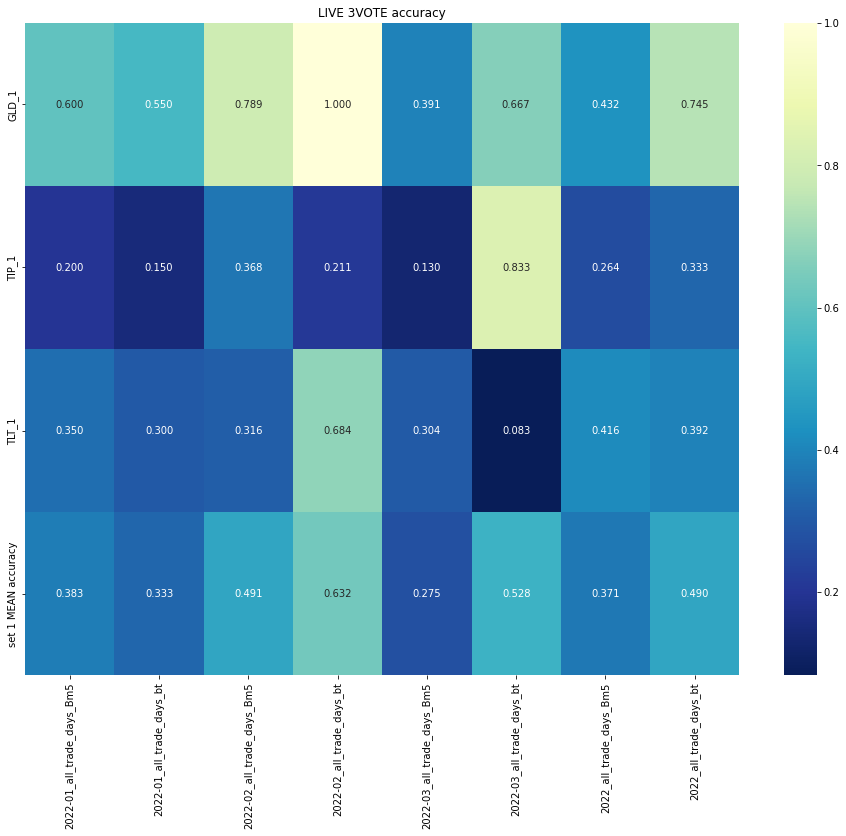

In [12]:
plt.figure(figsize = (16,12))
plt.title("LIVE 3VOTE accuracy")
sns.heatmap(vote_acc_df.dropna(), annot=True, fmt='.3f', cmap="YlGnBu_r")

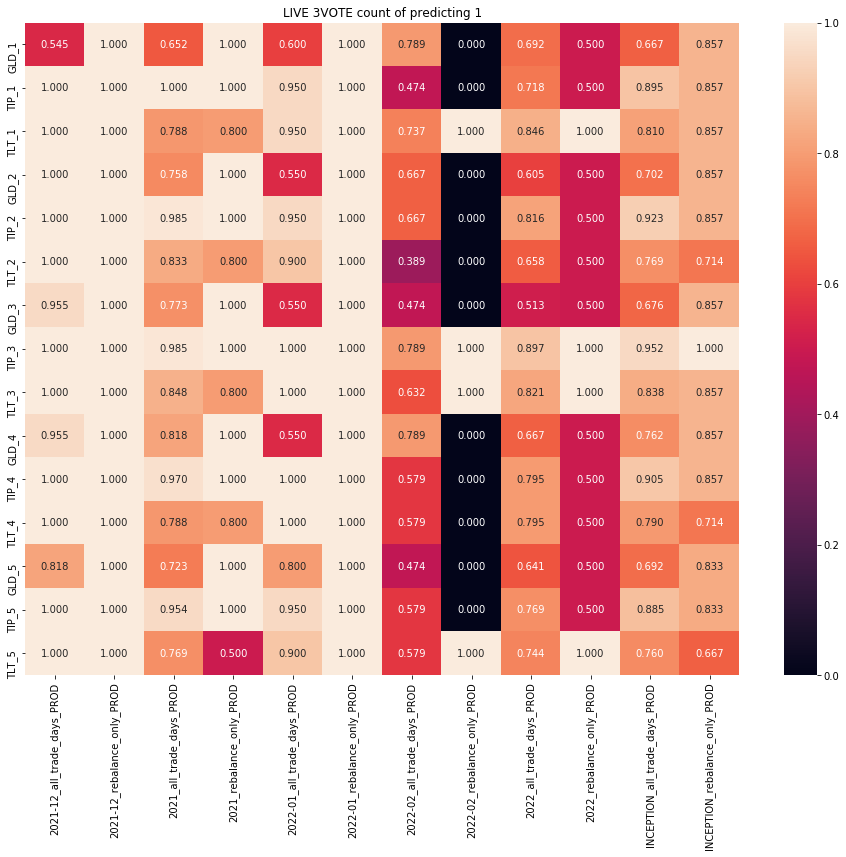

In [12]:
plt.figure(figsize = (16,12))
plt.title("LIVE 3VOTE count of predicting 1")
sns.heatmap(count1, annot=True, fmt='.3f')

## BETA

In [13]:
sites = ['UAT']
ensemble_file = 'beta_vote3ETFs_preds.csv'
rb_freq = 'W'

cases = [
    (None, rb_freq), (None, False),
    (tomonth_str, rb_freq), (tomonth_str, False),
    (lastmonth_str, rb_freq), (lastmonth_str, False),
    (prevmonth_str, rb_freq), (prevmonth_str, False),
    (str(thisyear), rb_freq), (str(thisyear), False), 
    (str(prevyear), rb_freq), (str(prevyear), False),
]

vote_acc_df = pd.DataFrame()
count1 = pd.DataFrame()
count_preds = pd.DataFrame()
for site in sites:
    # ensemble
    vote_file = os.path.join(os.path.join(record_fn, '{}_{}'.format(site, ensemble_file)))
    if not os.path.exists(vote_file):
        continue

    vote_df = get_3vote(vote_file)
    print("**********************************vote_file\n ", vote_file)
    for setID in list(set(vote_df.columns.get_level_values(0))):
        if setID == 0:
            continue
        tmp_df = vote_df[setID]
        
        subset_vote_acc_df = pd.DataFrame()
        subset_count1 = pd.DataFrame()
        subset_count_preds = pd.DataFrame()
        for case in cases:
            name = ""
            if case[0] is None:
                name += 'INCEPTION'
            else:
                name += case[0]

            if case[1]:
                name += '_rebalance_only'
            else:
                name += '_all_trade_days'
            name += "_" + site
            print("======={}======".format(name))
            case_acc, case_count1, case_preds_count = get_metircs(tmp_df, tradedate_file, case[0], case[1])

            case_acc.index = ["{}_{}".format(col, setID) for col in case_acc.index]
            subset_vote_acc_df[name] = case_acc
            case_count1.index = ["{}_{}".format(col, setID) for col in case_count1.index]
            subset_count1[name] = case_count1
            case_preds_count.index = ["{}_{}".format(col, setID) for col in case_preds_count.index]
            subset_count_preds[name] = case_preds_count

        subset_count1 = subset_count1.dropna(axis=1, how='all')
        subset_count1 = subset_count1.sort_index().sort_index(axis=1)
        count1 = pd.concat([count1, subset_count1])

        subset_count_preds = subset_count_preds.sort_index()
        subset_count_preds.loc['set {} total number of preds'.format(setID), :] = subset_count_preds.sum()
        if subset_count_preds.columns[0] in count_preds.columns:
            count_preds = pd.concat([count_preds, subset_count_preds])
        else:
            count_preds = pd.concat([count_preds, subset_count_preds], axis=1)

        subset_vote_acc_df = subset_vote_acc_df.dropna(axis=1, how='all')
        subset_vote_acc_df = subset_vote_acc_df.sort_index()
        subset_vote_acc_df.loc['set {} MEAN accuracy'.format(setID), :] = subset_vote_acc_df.mean()

        if subset_vote_acc_df.columns[0] in vote_acc_df.columns:
            vote_acc_df = pd.concat([vote_acc_df, subset_vote_acc_df])
        else:
            vote_acc_df = pd.concat([vote_acc_df, subset_vote_acc_df], axis=1)
            
count1 = count1.sort_index(axis=1)
count_preds = count_preds.sort_index(axis=1)
vote_acc_df = vote_acc_df.sort_index(axis=1)

**********************************vote_file
  data\UAT_beta_vote3ETFs_preds.csv
=======INCEPTION_rebalance_only_UAT======
=======INCEPTION_all_trade_days_UAT======
=======2022-02_rebalance_only_UAT======
=======2022-02_all_trade_days_UAT======
=======2022-01_rebalance_only_UAT======
=======2022-01_all_trade_days_UAT======
=======2021-12_rebalance_only_UAT======
=======2021-12_all_trade_days_UAT======
=======2022_rebalance_only_UAT======
=======2022_all_trade_days_UAT======
=======2021_rebalance_only_UAT======
=======2021_all_trade_days_UAT======
=======INCEPTION_rebalance_only_UAT======
=======INCEPTION_all_trade_days_UAT======
=======2022-02_rebalance_only_UAT======
=======2022-02_all_trade_days_UAT======
=======2022-01_rebalance_only_UAT======
=======2022-01_all_trade_days_UAT======
=======2021-12_rebalance_only_UAT======
=======2021-12_all_trade_days_UAT======
=======2022_rebalance_only_UAT======
=======2022_all_trade_days_UAT======
=======2021_rebalance_only_UAT======
=======2021_a

In [14]:
display = pd.concat(
    [vote_acc_df.loc[vote_acc_df.index.str.contains('MEAN accuracy'), :].T,
     count_preds.loc[count_preds.index.str.contains('total number of preds'), :].T], axis=1).dropna(how='all')
display.T.sort_index().T

,set 1 MEAN accuracy,set 1 total number of preds,set 2 MEAN accuracy,set 2 total number of preds,set 3 MEAN accuracy,set 3 total number of preds,set 4 MEAN accuracy,set 4 total number of preds,set 5 MEAN accuracy,set 5 total number of preds
2021-12_all_trade_days_UAT,0.363636,66.0,0.378788,66.0,0.393939,66.0,0.378788,66.0,0.378788,66.0
2021-12_rebalance_only_UAT,0.333333,15.0,0.266667,15.0,0.333333,15.0,0.266667,15.0,0.266667,15.0
2021_all_trade_days_UAT,0.520768,263.0,0.505617,263.0,0.501698,263.0,0.486590,263.0,0.531224,239.0
2021_rebalance_only_UAT,0.487179,78.0,0.487179,78.0,0.487179,78.0,0.474359,78.0,0.518519,54.0
2022-01_all_trade_days_UAT,0.316667,60.0,0.358333,56.0,0.300000,60.0,0.300000,60.0,0.358333,56.0
2022-01_rebalance_only_UAT,0.266667,15.0,0.350000,14.0,0.266667,15.0,0.266667,15.0,0.350000,14.0
2022-02_all_trade_days_UAT,0.629630,27.0,0.518519,27.0,0.481481,27.0,0.444444,27.0,0.518519,27.0
2022-02_rebalance_only_UAT,0.833333,6.0,1.000000,6.0,0.833333,6.0,0.666667,6.0,0.666667,6.0
2022_all_trade_days_UAT,0.413793,87.0,0.409195,83.0,0.356322,87.0,0.344828,87.0,0.411034,83.0
2022_rebalance_only_UAT,0.333333,18.0,0.466667,17.0,0.333333,18.0,0.333333,18.0,0.344444,17.0


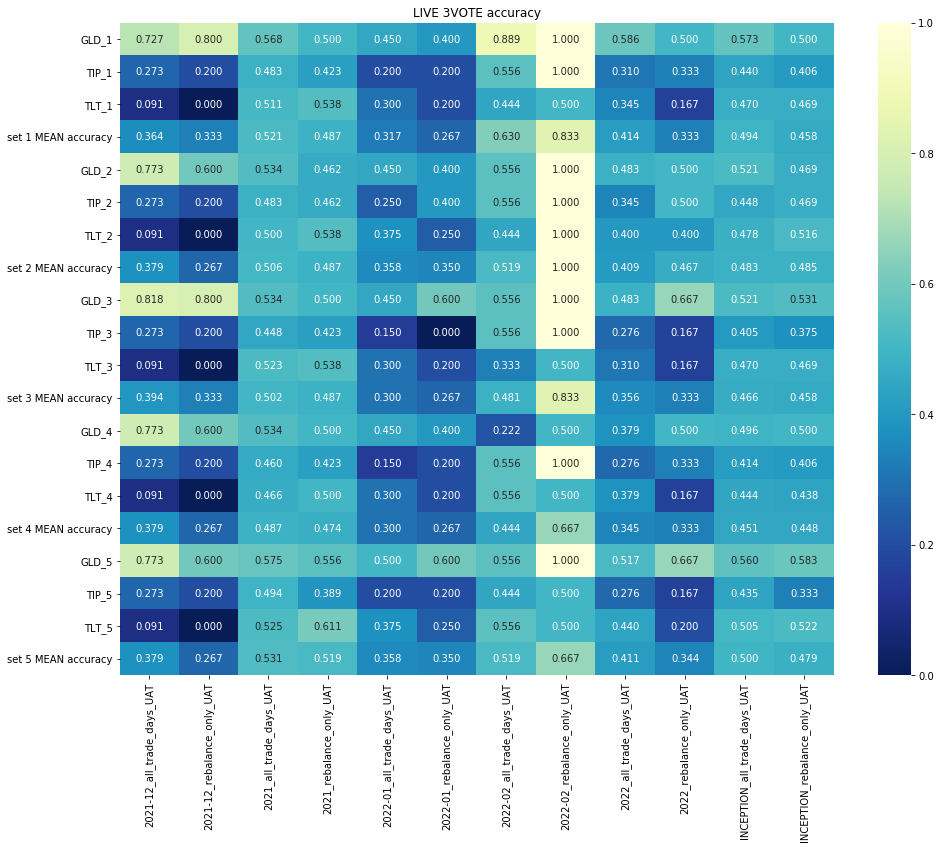

In [15]:
plt.figure(figsize = (16,12))
plt.title("LIVE 3VOTE accuracy")
sns.heatmap(vote_acc_df, annot=True, fmt='.3f', cmap="YlGnBu_r")

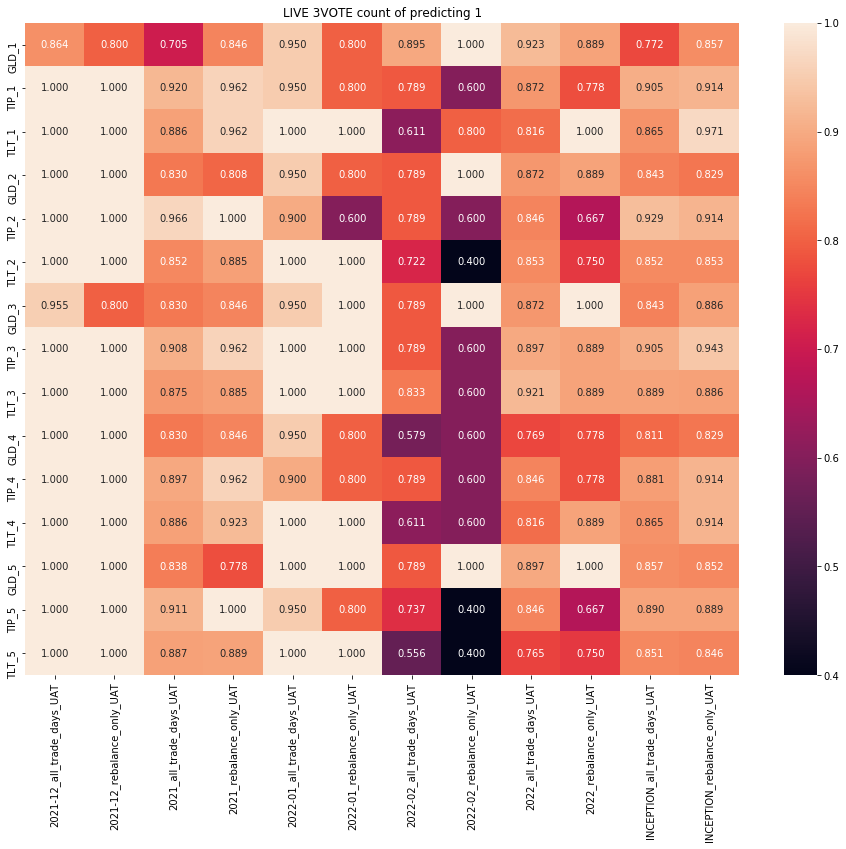

In [16]:
plt.figure(figsize = (16,12))
plt.title("LIVE 3VOTE count of predicting 1")
sns.heatmap(count1, annot=True, fmt='.3f')